In [1]:
import sys
import sys
sys.path.append("../../xapres/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import pandas as pd
importlib.reload(ApRESDefs)

<module 'ApRESDefs' from '/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py'>

In [2]:
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    17:46:06 	 ApRESDefs.py @function _setup_logging line 490 - Stream logging level set to DEBUG
DEBUG    17:46:06 	 ApRESDefs.py @function _setup_logging line 491 - Add console handler to logger
DEBUG    17:46:06 	 ApRESDefs.py @function _setup_logging line 504 - File logging level set to DEBUG


In [3]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")


In [4]:
ds_101

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11723,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [5]:
ds_101.nbytes/1e9

202.513838596

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36673")
client

<Client: 'tcp://127.0.0.1:36673' processes=0 threads=0, memory=0 B>

Start off by plotting raw data for the different stations and attenuator settings

In [7]:
def profile_plot(ax,station_ds,name):
    ds = xa.dB(station_ds)
    ds.plot(ax=ax,x='time')
    ax.invert_yaxis()
    ax.set_title(name)
    

In [8]:
ds_101_raw = ds_101.profile_stacked
ds_103_raw = ds_103.profile_stacked
ds_104_raw = ds_104.profile_stacked


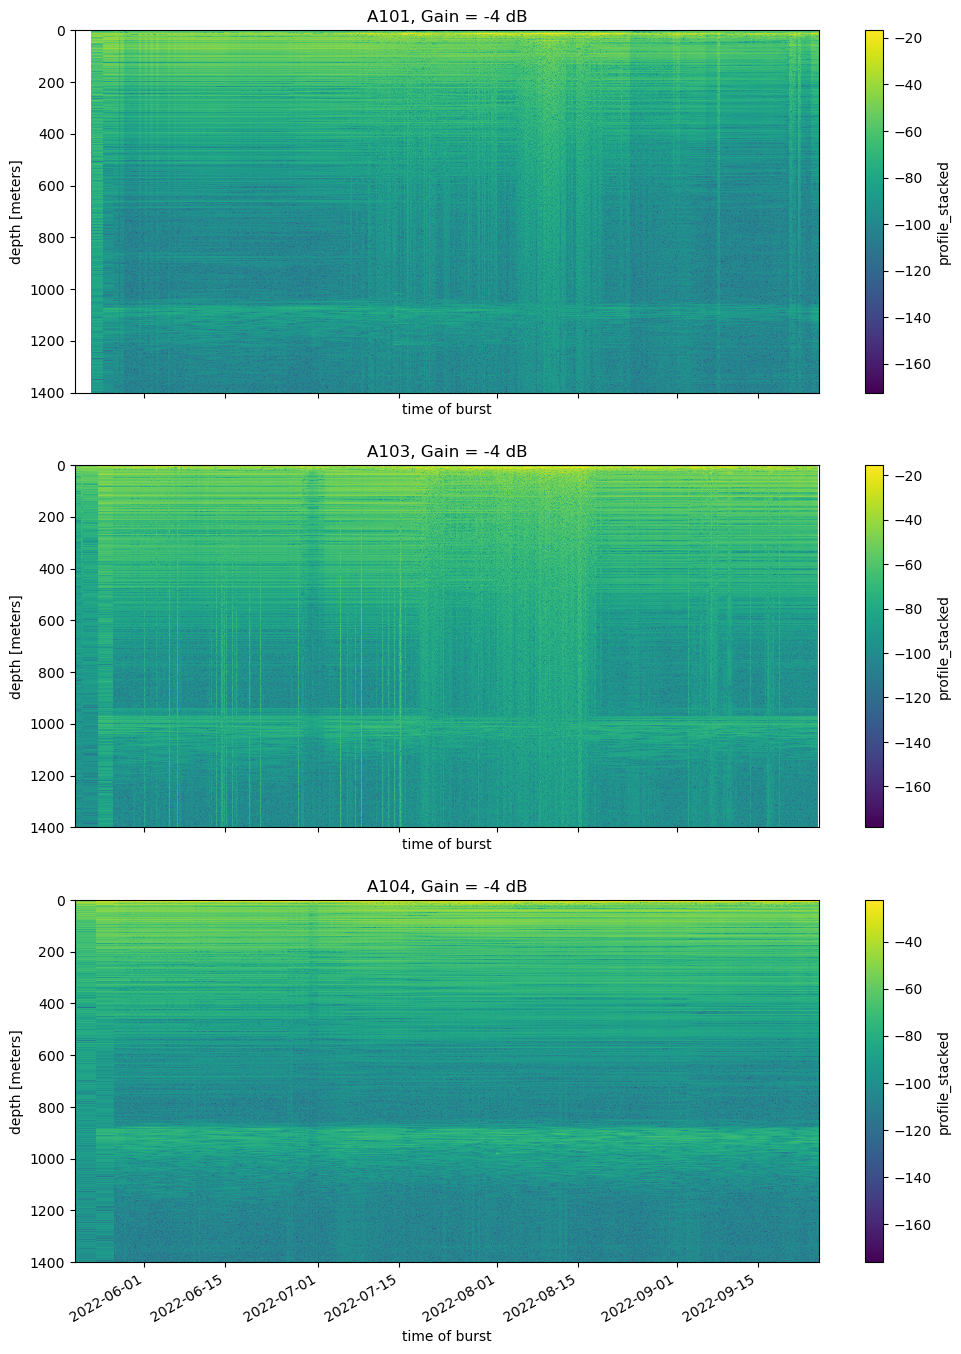

In [9]:
fig = plt.figure(figsize=(12, 16))

ax = fig.subplots(nrows=3,ncols=1, sharex=True, sharey=True)
for i in [0]:
    profile_plot(ax[0],ds_101_raw.isel(attenuator_setting_pair=i),f'A101, Gain = {ds_101_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')
    profile_plot(ax[1],ds_103_raw.isel(attenuator_setting_pair=i),f'A103, Gain = {ds_103_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')
    profile_plot(ax[2],ds_104_raw.isel(attenuator_setting_pair=i),f'A104, Gain = {ds_104_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')

In [10]:
ds_101_hourly = ds_101.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()
ds_103_hourly = ds_103.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()
ds_104_hourly = ds_104.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()


In [11]:
date_range = xr.date_range('2022-07-01T12:00:00.000000000','2022-07-30T12:00:00.000000000',freq='6H')

ds_101_resample = ds_101_hourly.sel(time=date_range,method='nearest')
ds_103_resample = ds_103_hourly.sel(time=date_range,method='nearest')
ds_104_resample = ds_104_hourly.sel(time=date_range,method='nearest')


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


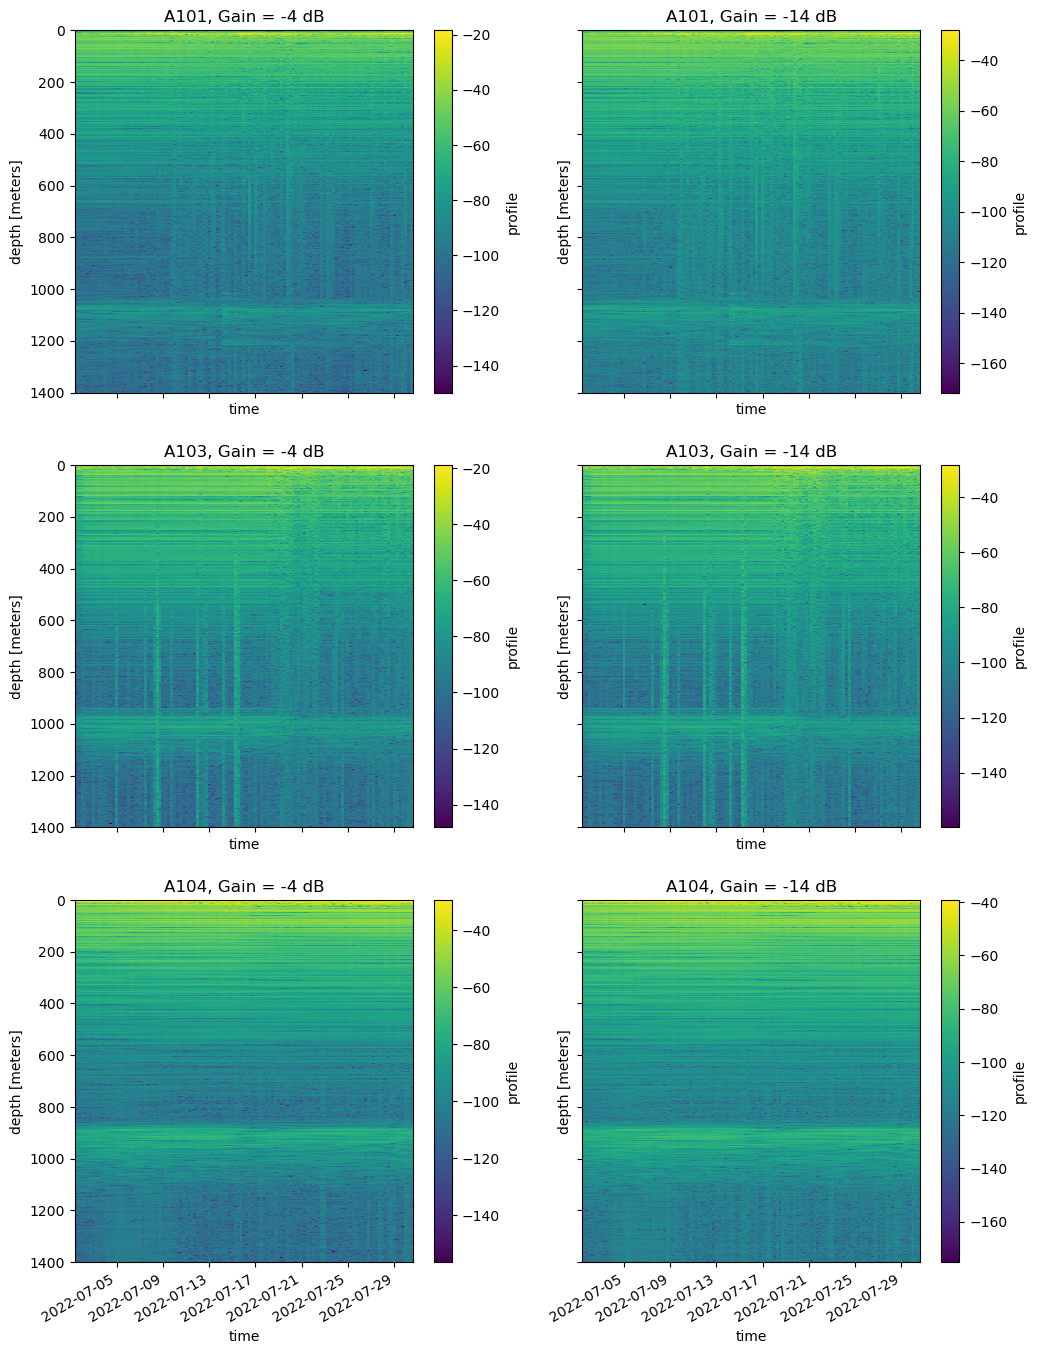

In [13]:
fig = plt.figure(figsize=(12, 16))

ax = fig.subplots(nrows=3,ncols=2, sharex=True, sharey=True)
for i in [0,1]:
    profile_plot(ax[0][i],ds_101_resample.isel(attenuator_setting_pair=i),f'A101, Gain = {ds_101_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[1][i],ds_103_resample.isel(attenuator_setting_pair=i),f'A103, Gain = {ds_103_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[2][i],ds_104_resample.isel(attenuator_setting_pair=i),f'A104, Gain = {ds_104_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')

In [15]:
ds_101_6hourly = ds_101.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='6H').mean(dim='time').compute()
ds_103_6hourly = ds_103.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='6H').mean(dim='time').compute()
ds_104_6hourly = ds_104.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='6H').mean(dim='time').compute()


In [16]:
date_range = xr.date_range('2022-07-01T12:00:00.000000000','2022-07-30T12:00:00.000000000',freq='1D')

ds_101_resample = ds_101_6hourly.sel(time=date_range,method='nearest')
ds_103_resample = ds_103_6hourly.sel(time=date_range,method='nearest')
ds_104_resample = ds_104_6hourly.sel(time=date_range,method='nearest')


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


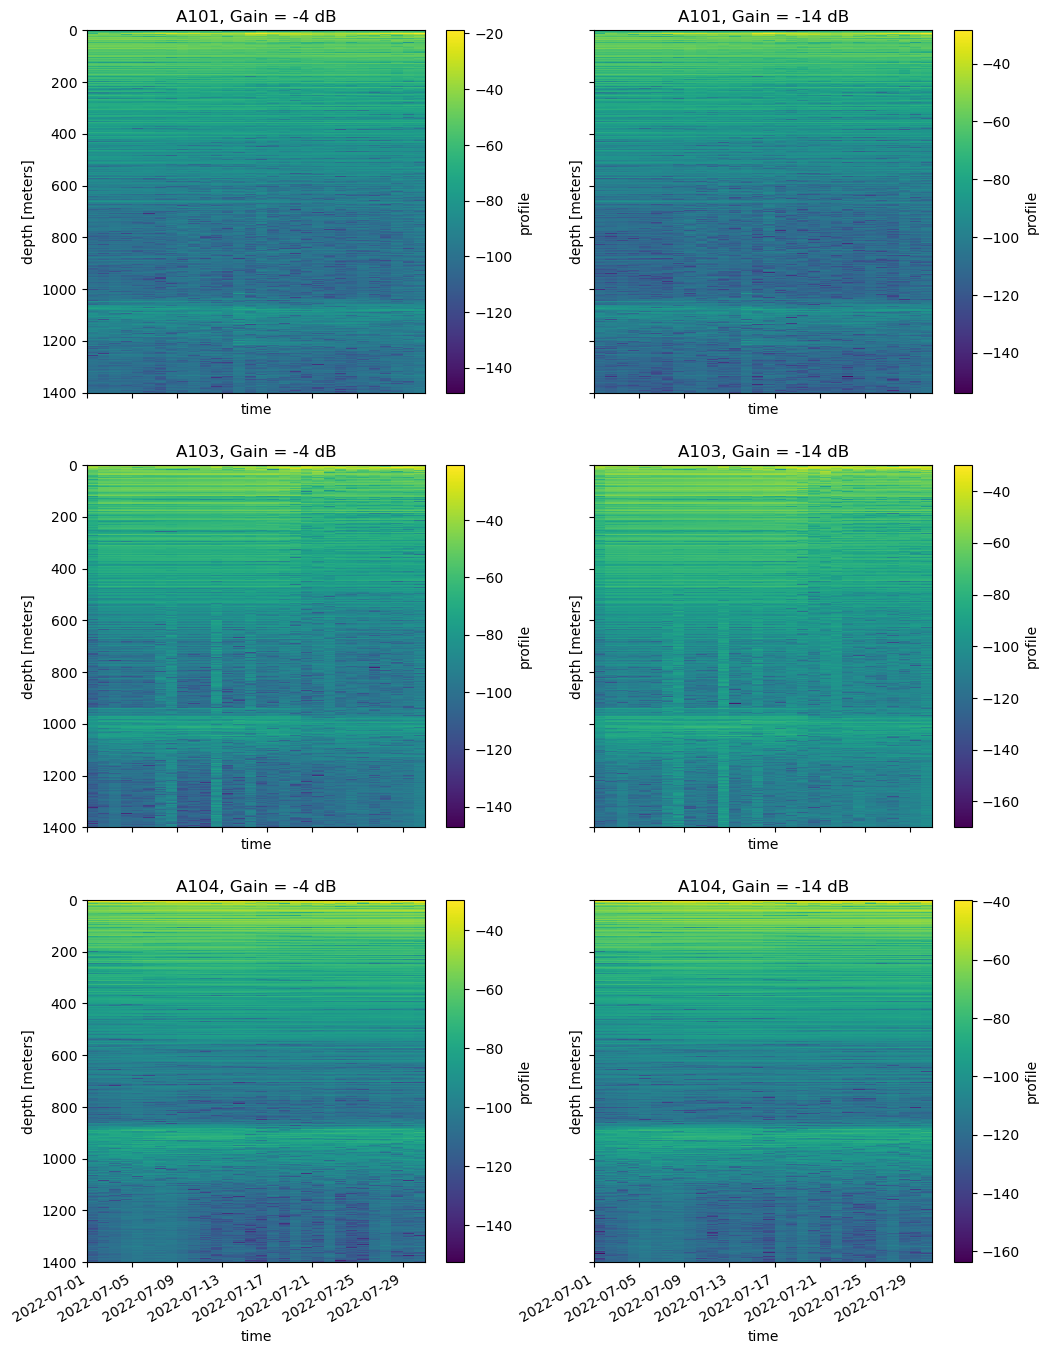

In [17]:
fig = plt.figure(figsize=(12, 16))

ax = fig.subplots(nrows=3,ncols=2, sharex=True, sharey=True)
for i in [0,1]:
    profile_plot(ax[0][i],ds_101_resample.isel(attenuator_setting_pair=i),f'A101, Gain = {ds_101_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[1][i],ds_103_resample.isel(attenuator_setting_pair=i),f'A103, Gain = {ds_103_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[2][i],ds_104_resample.isel(attenuator_setting_pair=i),f'A104, Gain = {ds_104_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')

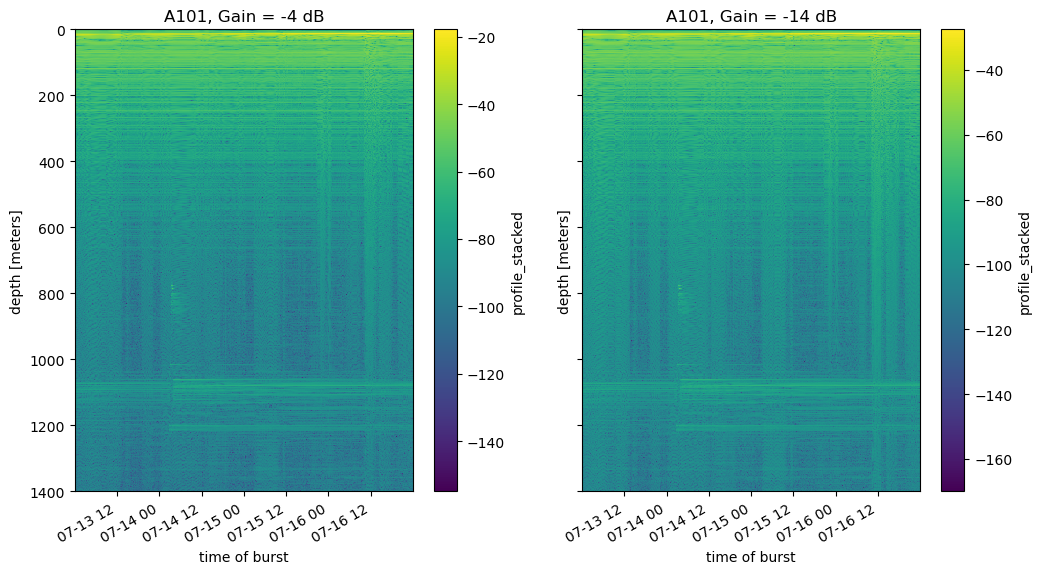

In [16]:
fig = plt.figure(figsize=(12, 6))

ax = fig.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
for i in [0,1]:
    profile_plot(ax[i],ds_101_raw.isel(attenuator_setting_pair=i).where(ds_101_raw.time > pd.to_datetime("2022-07-13"),drop=True).where(ds_101_raw.time < pd.to_datetime("2022-07-17"),drop=True),f'A101, Gain = {ds_101_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')
    #profile_plot(ax[1][i],ds_103_raw.isel(attenuator_setting_pair=i).where(ds_103_raw.time > pd.to_datetime("2022-07-13"),drop=True).where(ds_103_raw.time < pd.to_datetime("2022-07-17"),drop=True),f'A103, Gain = {ds_103_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')
    #profile_plot(ax[2][i],ds_104_raw.isel(attenuator_setting_pair=i).where(ds_104_raw.time > pd.to_datetime("2022-07-13"),drop=True).where(ds_104_raw.time < pd.to_datetime("2022-07-17"),drop=True),f'A104, Gain = {ds_104_raw.isel(attenuator_setting_pair=i).AFGain.data.compute()} dB')

In [31]:
ds_101_hourly = ds_101.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()
ds_103_hourly = ds_103.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()
ds_104_hourly = ds_104.isel(chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()


In [32]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-17T12:00:00.000000000',freq='3H')

ds_101_resample = ds_101_hourly.sel(time=date_range,method='nearest')
ds_103_resample = ds_103_hourly.sel(time=date_range,method='nearest')
ds_104_resample = ds_104_hourly.sel(time=date_range,method='nearest')


/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/cftime_offsets.py:1134: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


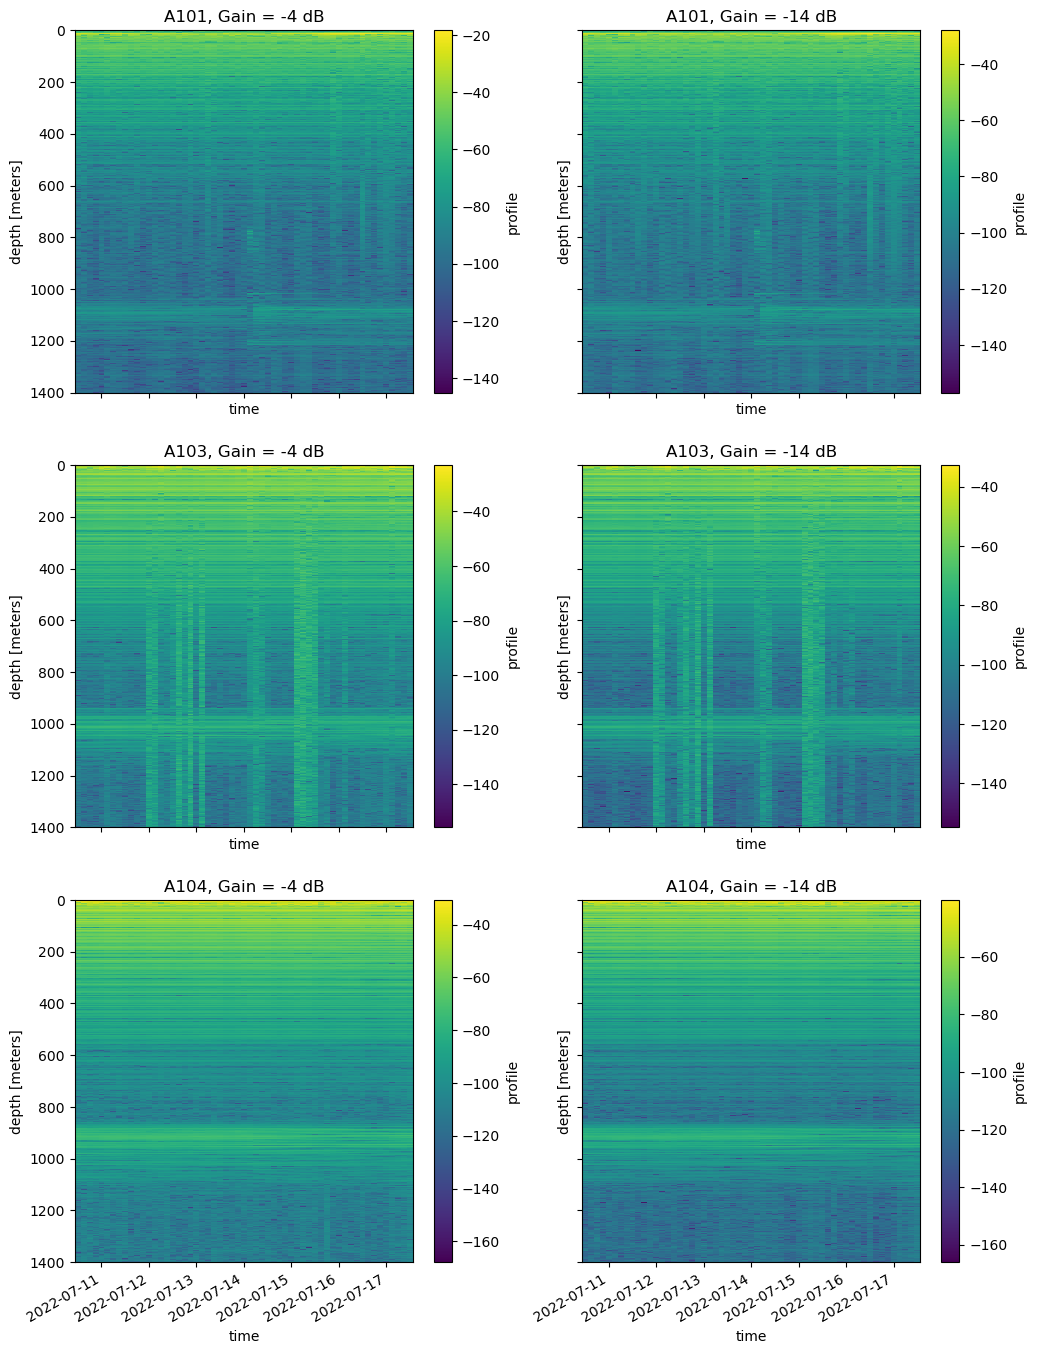

In [33]:
fig = plt.figure(figsize=(12, 16))

ax = fig.subplots(nrows=3,ncols=2, sharex=True, sharey=True)
for i in [0,1]:
    profile_plot(ax[0][i],ds_101_resample.isel(attenuator_setting_pair=i),f'A101, Gain = {ds_101_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[1][i],ds_103_resample.isel(attenuator_setting_pair=i),f'A103, Gain = {ds_103_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')
    profile_plot(ax[2][i],ds_104_resample.isel(attenuator_setting_pair=i),f'A104, Gain = {ds_104_resample.isel(attenuator_setting_pair=i).AFGain.data} dB')